In [1]:
%env DRJIT_LIBLLVM_PATH /usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1
!echo $DRJIT_LIBLLVM_PATH

env: DRJIT_LIBLLVM_PATH=/usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1
/usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1


In [2]:
%%bash
ln -sf /usr/lib/x86_64-linux-gnu/libstdc++.so.6 ${CONDA_PREFIX}/lib/libstdc++.so.6
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [3]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt
import time

mi.set_variant('cuda_ad_rgb')
# mi.set_variant('llvm_ad_rgb')

In [4]:
from furnace_scene import make_scene_uniform, visualize_scene
import numpy as np

color_ref = [0.2, 0.25, 0.7]
scene = make_scene_uniform(color_ref)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.24994497..2.4857507].


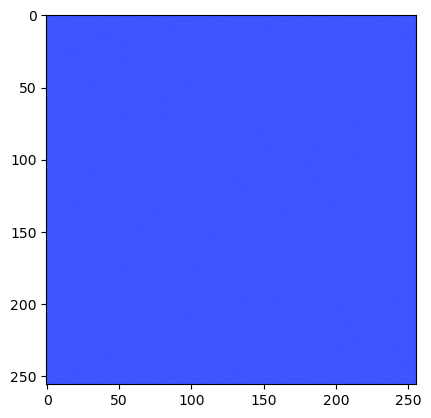

In [5]:
image = mi.render(scene)

import matplotlib.pyplot as plt
plt.imshow(image)

In [6]:
# from radiosity import SceneSurfaceSampler, RadianceCacheMITSUBA, compute_loss
# from visualizer import plot_sphere, plot_rays
# import polyscope as ps

# NUM_WI_DIRECTIONS  = 1 << 4
# SAMPLES_PER_RAY_LI = 1 << 4
# SAMPLES_PER_RAY_LO = 16
# NUM_GEO_SAMPLES = 1 << 0

# scene_sampler = SceneSurfaceSampler(scene)
# radiance_cache = RadianceCacheMITSUBA(scene, 
#                                       spp_per_wo=SAMPLES_PER_RAY_LO, 
#                                       spp_per_wi=SAMPLES_PER_RAY_LI)

# si = scene_sampler.sample(NUM_GEO_SAMPLES)[0]
# sampler = mi.load_dict({'type':'independent'})

# compute_loss(scene_sampler, radiance_cache, define_BSDF()[0], NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS)

# # lhs = radiance_cache.query_cached_Lo(sampler, si)

# # # lhs

# # Li, wi_local, si_flattened = radiance_cache.query_cached_Li(sampler, si, NUM_WI_DIRECTIONS)
# # ctx = mi.BSDFContext(mi.TransportMode.Radiance, mi.BSDFFlags.All)
# # f_io, pdf = define_BSDF()[0].eval_pdf(ctx, si = si_flattened, wo = wi_local)
# # integrand = f_io * Li #* dr.rcp(pdf)
# # rhs = dr.block_reduce(dr.ReduceOp.Add, integrand, block_size = NUM_WI_DIRECTIONS) / NUM_WI_DIRECTIONS

# # rhs



# # ps.init()
# # plot_sphere()
# # plot_rays(si.spawn_ray(si.to_world(si.wi)))
# # ps.show()

In [7]:
from radiosity import SceneSurfaceSampler, RadianceCacheMITSUBA, compute_loss

NUM_WI_DIRECTIONS = 32 # 32
SAMPLES_PER_RAY_LI = 32 # 32
SAMPLES_PER_RAY_LO = 128 # 128
NUM_GEO_SAMPLES = 4 # 128

scene_sampler = SceneSurfaceSampler(scene)
radiance_cache = RadianceCacheMITSUBA(scene, 
                                      spp_per_wo=SAMPLES_PER_RAY_LO, 
                                      spp_per_wi=SAMPLES_PER_RAY_LI)


In [8]:
from train import define_BSDF_uniform

# Initialize BSDF to train
bsdf_train, key = define_BSDF_uniform()
params = mi.traverse(bsdf_train)
opt = mi.ad.Adam(lr=0.05)
dr.enable_grad(params[key])
opt[key] = params[key]
params.update(opt)

losses = []
for it in range(100):
    time1 = time.time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss(scene_sampler, radiance_cache, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, it)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time.time()
    # print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}, p = {opt[key]}")
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [0.754149]: Loss = [0.321831]
Iteration 002 [0.012630]: Loss = [0.338898]
Iteration 003 [0.012201]: Loss = [0.300979]
Iteration 004 [0.011827]: Loss = [0.30576]
Iteration 005 [0.011783]: Loss = [0.336283]
Iteration 006 [0.012140]: Loss = [0.2958]
Iteration 007 [0.012352]: Loss = [0.31847]
Iteration 008 [0.012184]: Loss = [0.309079]
Iteration 009 [0.011920]: Loss = [0.342655]
Iteration 010 [0.011826]: Loss = [0.353514]
Iteration 011 [0.012091]: Loss = [0.291788]
Iteration 012 [0.012077]: Loss = [0.241633]
Iteration 013 [0.010738]: Loss = [0.300013]
Iteration 014 [0.010813]: Loss = [0.280225]
Iteration 015 [0.012194]: Loss = [0.354115]
Iteration 016 [0.011061]: Loss = [0.306805]
Iteration 017 [0.010749]: Loss = [0.303107]
Iteration 018 [0.010799]: Loss = [0.279726]
Iteration 019 [0.010396]: Loss = [0.298847]
Iteration 020 [0.010502]: Loss = [0.250849]
Iteration 021 [0.010808]: Loss = [0.320289]
Iteration 022 [0.010391]: Loss = [0.312614]
Iteration 023 [0.010542]: Loss = [0.

Reference albedo: [0.2, 0.25, 0.7]
Optimized albedo: [[[0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  .. 58 skipped ..,
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5]],
 [[0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  .. 58 skipped ..,
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5]],
 [[0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  .. 58 skipped ..,
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5]],
 .. 58 skipped ..,
 [[0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  .. 58 skipped ..,
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5]],
 [[0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  .. 58 skipped ..,
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5]],
 [[0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  .. 58 skipped ..,
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5]]]


Text(0, 0.5, 'Loss')

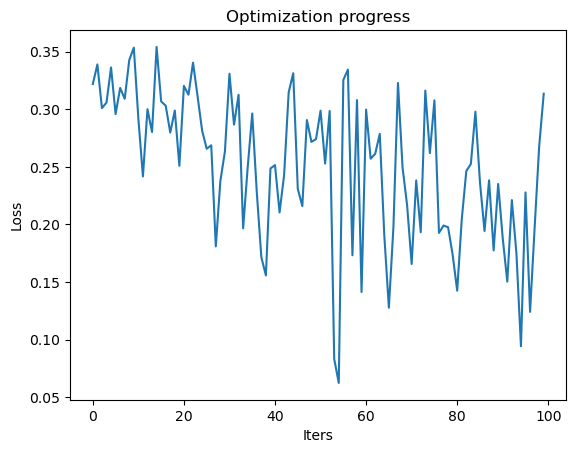

In [9]:
import matplotlib.pyplot as plt

print("Reference albedo:", color_ref)
print("Optimized albedo:", params[key])

plt.figure()
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")